In [30]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation

In [31]:
import pandas as pd

all_games_df = pd.read_csv("data/all_games.csv")
all_games_df.drop("Unnamed: 0", axis=1,inplace=True)
# Data Preparation
from api_helpers.game_stats_helpers import load_past_n_games
columns = ["FG_PCT", "FG3_PCT", "FTM", "OREB", "DREB", "REB", "AST"]
columns_a = [column + "_A" for column in columns]
columns_b = [column + "_B" for column in columns]

n_games_df = load_past_n_games(all_games_df=all_games_df, columns=columns, n=10)
n_games_df = n_games_df.dropna()
merged_data = pd.merge(
    all_games_df[columns_a + columns_b], n_games_df, left_index=True, right_index=True
)

In [32]:
n_games_df = n_games_df[n_games_df["WL_A"] != " "]
n_games_df

,GAME_ID,TEAM_ID_A,TEAM_ID_B,GAME_ID,WL_A,FG_PCT_A,FG3_PCT_A,FTM_A,OREB_A,DREB_A,REB_A,AST_A,FG_PCT_B,FG3_PCT_B,FTM_B,OREB_B,DREB_B,REB_B,AST_B
0,22301159,1610612737,1610612766,22301159,L,0.4826,0.3500,10.4,11.2,36.2,47.4,29.4,0.4658,0.3586,18.6,9.4,30.8,40.2,25.6
1,22301147,1610612737,1610612748,22301147,L,0.4826,0.3500,10.4,11.2,36.2,47.4,29.4,0.4742,0.3114,18.2,9.0,35.0,44.0,26.4
2,22301104,1610612737,1610612765,22301104,W,0.4826,0.3500,10.4,11.2,36.2,47.4,29.4,0.4452,0.3226,18.6,9.8,27.6,37.4,22.0
3,22301076,1610612737,1610612749,22301076,L,0.4826,0.3500,10.4,11.2,36.2,47.4,29.4,0.4580,0.3514,16.8,10.4,36.0,46.4,23.8
4,22301060,1610612737,1610612738,22301060,W,0.4826,0.3500,10.4,11.2,36.2,47.4,29.4,0.4960,0.3890,15.8,9.4,31.8,41.2,25.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52802,28800140,1610612766,1610612764,28800140,L,0.4734,0.2166,18.0,12.8,32.0,44.8,26.4,0.4832,0.1000,23.0,15.2,29.4,44.6,24.8
52803,28800115,1610612766,1610612765,28800115,L,0.4906,0.2500,20.4,11.4,29.2,40.6,25.8,0.5160,0.4200,17.8,12.0,29.4,41.4,24.2
52804,28800071,1610612766,1610612751,28800071,L,0.4820,0.2000,17.8,11.4,29.0,40.4,24.4,0.4440,0.2966,23.2,13.4,31.4,44.8,18.8
52805,28800024,1610612766,1610612746,28800024,W,0.4760,0.2000,18.6,13.4,27.4,40.8,24.0,0.4858,0.0800,21.2,13.2,31.8,45.0,22.2


In [33]:



columns_x = columns_a + columns_b
columns_x = [column + "_x" for column in columns_x]
X = merged_data[columns_x]
columns_y = columns_a + columns_b
columns_y = [column + "_y" for column in columns_y]
y = merged_data[columns_y]
## Test Train Split
from sklearn.model_selection import train_test_split
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
# Preloading Neural Network
# Predicting Game Outcome
from tensorflow.keras.models import model_from_json

# load json and create model
json_file = open("tuned_nn.json", "r")
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("tuned.weights.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

y_final_true = all_games_df["WL_A"].loc[y_test.index].to_frame()
y_final_true.replace("W",1,inplace=True)
y_final_true.replace("L",0,inplace=True)
y_final_true.replace(" ",0,inplace=True)
y_final_true = list(y_final_true["WL_A"])

Loaded model from disk


/tmp/ipykernel_284158/473199277.py:34: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_final_true.replace(" ",0,inplace=True)


329/329 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step
<class 'int'>
Best Neural Network classification report:
              precision    recall  f1-score   support

           0       0.66      0.56      0.61      4230
           1       0.73      0.81      0.77      6281

    accuracy                           0.71     10511
   macro avg       0.70      0.69      0.69     10511
weighted avg       0.71      0.71      0.71     10511



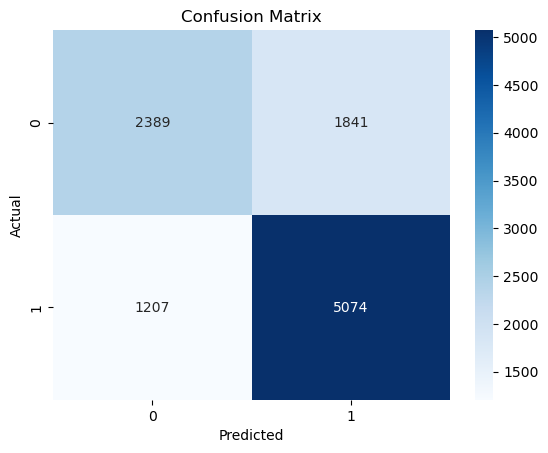

In [34]:
from catboost import CatBoostRegressor
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# create an xgboost regression model

param = {'loss_function': 'MultiRMSE',"iterations": 100, "learning_rate": 0.1, "depth": 8,"verbose":False}

model = CatBoostRegressor(**param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

scaler = joblib.load("scaler.bin")

y_final_pred = loaded_model.predict(scaler.transform(y_pred))
y_pred_true = np.argmax(y_final_pred, axis=1)

y_pred_true = y_pred_true.tolist()
print(type(y_pred_true[0]))


# Evaluate the model
print("Best Neural Network classification report:")
print(classification_report(y_final_true, list(y_pred_true)))

# Confusion matrix
conf_matrix_nn = confusion_matrix(y_final_true, list(y_pred_true))
sns.heatmap(conf_matrix_nn, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()